Code to implement a very basic TOF reconstructor to coincidence data output by GATE

In [1]:
# some functions are defined in the file called pet_helpers.py
# they will be available with p.function_name()
# Example: 
import pet_functions as p
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import numpy as np
import time
from scipy.interpolate import griddata

from scrollview import ScrollView

#importing and making a change to matplotlib to avoid overflow while plotting
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

p.hello()

Hello Ryan


In [2]:
##### %matplotlib widget
import os
from pathlib import Path
# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
print(cwd)
folder30 = Path(os.path.join(cwd, './results_patient_30degrees'))
folder60 = Path(os.path.join(cwd, './results_patient_60degrees'))
folder90 = Path(os.path.join(cwd, './results_patient_90degrees'))
folder120 = Path(os.path.join(cwd, './results_patient_120degrees'))
folder240 = Path(os.path.join(cwd, './results_patient_240degrees'))

#folder = Path(os.path.join(cwd, './Quasar_GateLab_Results/output_deg90_prim1e9_center_15MV'))

#folder = Path(os.path.join(cwd, './Partial/output_1e5_box_10cm_4missing'))


D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results


In [3]:
# opening the files
import uproot
def read_root_tree(folder, filename):
    filename = os.path.join(folder, filename)
    print(filename)
    f = uproot.open(filename)
    t = f['tree'] #what does this line do?
    print(f'Reading file {filename}')
    return t

In [4]:
coinc30 = read_root_tree(folder30,'STIR.Coincidences.root')
coinc60 = read_root_tree(folder60,'STIR.Coincidences.root')
coinc90 = read_root_tree(folder90,'STIR.Coincidences.root')
coinc120 = read_root_tree(folder120,'STIR.Coincidences.root')
coinc240 = read_root_tree(folder240,'STIR.Coincidences.root')

D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_30degrees\STIR.Coincidences.root
Reading file D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_30degrees\STIR.Coincidences.root
D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_60degrees\STIR.Coincidences.root
Reading file D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_60degrees\STIR.Coincidences.root
D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_90degrees\STIR.Coincidences.root
Reading file D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_90degrees\STIR.Coincidences.root
D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_GateLab_Results\results_patient_120degrees\STIR.Coincidences.root
Reading file D:\willi\OneDrive\Documents\BWH\Research\GATE\Macros\Patient_Gate

In [5]:
#x1,x2,y1,y2,z1,z2,t1,t2 = p.get_TOF_data(coinc)

In [6]:
# in the initial simulation the hits are not stored. 
# It can be enabled with the following macro:
# /gate/output/root/setRootHitFlag 1 in the file output.mac
# warning : it lead to a very large output file
#print('Number of hits:', len(hits))
#print('Number of Trees in Coincidences:', len(coinc))
#print('Coincidences keys: ')
#for i in coinc.keys():
#    print(i, '| ', end=" ")
#print(" ")

In [7]:
#mini TOF Reconstructor

def TOF(coinc):
    #function to do a quick TOF reconstruction from coincidence data
    
    #the basic idea is to take the global positions and time of both coincidence points,
    # then the offset from the center will be c*dt in the direction of the first coincidence, where dt is the difference
    # in times between coinc 1 and coinc 2 and c is the speed of light
    
    #for beginning, index to plot for verification and working with single data points
    
    #speed of light in mm/s
    c = 2.99792*10**11 #mm/s
    
    #save global x,y,and t data for all coincidences
    x1,x2,y1,y2,z1,z2,t1,t2 = p.get_TOF_data(coinc)
    print("Number of Coinc:",len(x1))
    #print(x1)
    #define lists to hold reconstruction coordinates
    xrec = []
    yrec = []
    zrec = []
    x1out = []
    y1out = []
    z1out = []
    x2out = []
    y2out = []
    z2out = []

    for N in range(0,len(x1)):
        #distance = np.sqrt((x2[N]-x1[N])**2 + (y2[N]-y1[N])**2 + (z2[N]-z1[N])**2)
        
       # print("Z1,Z2 = ",z1[N],z2[N])
        
        #find midpoint of line
        xhalf = (x1[N]+x2[N])/2
        yhalf = (y1[N]+y2[N])/2
        zhalf = (z1[N]+z2[N])/2
       # print("zhalf = ", zhalf)
                
        #define x-axis for plotting
        x = np.linspace(x1[N],x2[N],1000)

        #time delay between coincidences
        toff = t2[N]-t1[N]

        #offset from midpoint that is along the fitted line     
        doff = (toff)*c/2
        
        #need to displace the midpoint in 3D based on the angles between the LOR and the x-axis.
        #define theta as the angle between the projection of the LOR on the x-y axis and the x-axis.
        theta = np.arctan((y2[N]-y1[N])/(x2[N]-x1[N]))
        #define alpha as the angle between the projection of the LOR on the x-z axis and the x-axis.
        alpha = np.arctan((z2[N]-z1[N])/(x2[N]-x1[N]))
        #print("alpha = ",alpha)
        #calculate the offests in each dimension
        doffx = doff*np.cos(abs(theta))*np.cos(abs(alpha))
        doffy = doff*np.sin(abs(theta))
        doffz = doff*np.cos(abs(theta))*np.sin(abs(alpha))
        #print("doffz = ",doffz)
        #add the offsets to the midpoint to calculate the reconstruction point
        xrec_point = xhalf + (x1[N]/abs(x1[N]))*doffx
        yrec_point = yhalf + (y1[N]/abs(y1[N]))*doffy
        zrec_point = zhalf + (z1[N]/abs(z1[N]))*doffz
        #print("zrec_point = ",zrec_point)
       # print("____________________________________________________________")
        #print some values for debugging
        #print("tdiff = ",t2[N]-t1[N],"seconds")    
        #print("offset = ",doff, "mm")
        #if toff < 3*10**(-9):
        #    #calculate the angle between line parallel to x-axis and LOR
        #    theta = np.arctan(m)#

        #    #calculate the reconstruction position (in the direction of (x1,y1))
        #    xrec_point = xhalf + (x1[N]/abs(x1[N]))*doff*np.cos(abs(theta))
        #    yrec_point = yhalf + (y1[N]/abs(y1[N]))*doff*np.sin(abs(theta))

        xrec.append(xrec_point)
        yrec.append(yrec_point)
        zrec.append(zrec_point)
        
    return xrec, yrec, zrec
    

## Center

In [8]:
import time 
time1=time.time()
xrec30, yrec30, zrec30 = TOF(coinc30)
xrec60, yrec60, zrec60 = TOF(coinc60)
xrec90, yrec90, zrec90 = TOF(coinc90)
xrec120, yrec120, zrec120 = TOF(coinc120)
xrec240, yrec240, zrec240 = TOF(coinc240)
time2=time.time()
print("time taken:",(time2-time1)/60, "minutes")

Number of Coinc: 34262
Number of Coinc: 45639
Number of Coinc: 47833
Number of Coinc: 41539
Number of Coinc: 49252
time taken: 2.342530596256256 minutes


In [9]:
xrec = np.concatenate((xrec30,xrec60,xrec90,xrec120,xrec240))
yrec = np.concatenate((yrec30,yrec60,yrec90,yrec120,yrec240))
zrec = np.concatenate((zrec30,zrec60,zrec90,zrec120,zrec240))
print(zrec)

[ 91.89034398  19.96129635  -5.8585424  ...  -3.2613451    8.17779213
 -54.91650686]


-231.0 119.0
-64.5 215.5


(array([-250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.]),
 [Text(-250.0, 0, '−250'),
  Text(-200.0, 0, '−200'),
  Text(-150.0, 0, '−150'),
  Text(-100.0, 0, '−100'),
  Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150')])

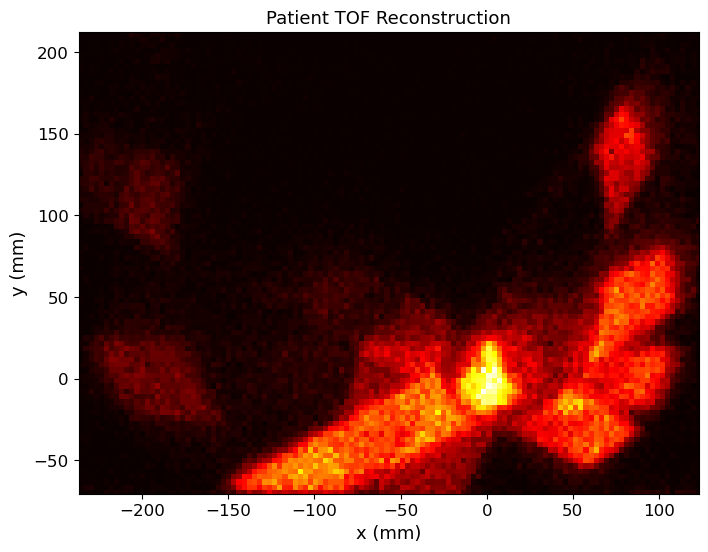

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
rec = plt.hist2d(xrec, yrec, bins=500, cmin = 0,cmap = "hot")
ax.set_xlabel('x (mm)',fontsize = 13)
ax.set_ylabel('y (mm)',fontsize =13)
ax.set_title('Patient TOF Reconstruction',fontsize=13)
boxheight = 100
#plt.hlines(boxheight,-boxheight,boxheight,color="red")
#plt.hlines(-boxheight,-boxheight,boxheight,color="red")
#plt.vlines(100,-boxheight,boxheight,color="red")
#plt.vlines(-100,-boxheight,boxheight,color="red")
#theta = np.linspace(0,np.pi)
#r=50
#off = 200
#plt.plot(r*np.cos(theta),r*np.sin(theta),color="blue")
#plt.plot(r*np.cos(theta),-r*np.sin(theta),color="blue")
#plt.plot(392.6*np.cos(theta),-392.6*np.sin(theta),color="black")
#plt.plot(392.6*np.cos(theta),392.6*np.sin(theta),color="black")

xlength = 350 #voxels, which amounts to 252mm
ylength = 280 #voxels which acmounts to 202mm

xoff = -56
yoff = 75.5

xlow = -xlength/2 + xoff
xhigh = xlength/2 + xoff

print(xlow,xhigh)

ylow = -ylength/2 + yoff
yhigh = ylength/2 + yoff

print(ylow,yhigh)

ax.set_xlim(-237.0, 123.0)
ax.set_ylim(-70.5, 212.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.colorbar(rec[3])

In [12]:
print(len(rec[0]))

500


In [13]:
#voxelize data in 3D
with open('patientx.txt', 'w') as outfile:
  outfile.write('\n'.join(str(i) for i in xrec))
with open('patienty.txt', 'w') as outfile:
  outfile.write('\n'.join(str(i) for i in yrec))
with open('patientz.txt', 'w') as outfile:
  outfile.write('\n'.join(str(i) for i in zrec))

In [14]:
#plot the ground truth in comparison

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from ipywidgets import interact
import os
from pathlib import Path


In [15]:
# This function is from https://github.com/rock-learning/pytransform3d/blob/7589e083a50597a75b12d745ebacaa7cc056cfbd/pytransform3d/rotations.py#L302
def matrix_from_axis_angle(a):
    """ Compute rotation matrix from axis-angle.
    This is called exponential map or Rodrigues' formula.
    Parameters
    ----------
    a : array-like, shape (4,)
        Axis of rotation and rotation angle: (x, y, z, angle)
    Returns
    -------
    R : array-like, shape (3, 3)
        Rotation matrix
    """
    ux, uy, uz, theta = a
    c = np.cos(theta)
    s = np.sin(theta)
    ci = 1.0 - c
    R = np.array([[ci * ux * ux + c,
                   ci * ux * uy - uz * s,
                   ci * ux * uz + uy * s],
                  [ci * uy * ux + uz * s,
                   ci * uy * uy + c,
                   ci * uy * uz - ux * s],
                  [ci * uz * ux - uy * s,
                   ci * uz * uy + ux * s,
                   ci * uz * uz + c],
                  ])

    # This is equivalent to
    # R = (np.eye(3) * np.cos(theta) +
    #      (1.0 - np.cos(theta)) * a[:3, np.newaxis].dot(a[np.newaxis, :3]) +
    #      cross_product_matrix(a[:3]) * np.sin(theta))

    return R


def resample(image, transform):
    """
    This function resamples (updates) an image using a specified transform
    :param image: The sitk image we are trying to transform
    :param transform: An sitk transform (ex. resizing, rotation, etc.
    :return: The transformed sitk image
    """
    reference_image = image
    interpolator = sitk.sitkLinear
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)


def get_center(img):
    """
    This function returns the physical center point of a 3d sitk image
    :param img: The sitk image we are trying to find the center of
    :return: The physical center point of the image
    """
    width, height, depth = img.GetSize()
    return img.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                              int(np.ceil(height/2)),
                                              int(np.ceil(depth/2))))


def rotation3d(image, theta_z, show=False):
    """
    This function rotates an image across each of the x, y, z axes by theta_x, theta_y, and theta_z degrees
    respectively
    :param image: An sitk MRI image
    :param theta_x: The amount of degrees the user wants the image rotated around the x axis
    :param theta_y: The amount of degrees the user wants the image rotated around the y axis
    :param theta_z: The amount of degrees the user wants the image rotated around the z axis
    :param show: Boolean, whether or not the user wants to see the result of the rotation
    :return: The rotated image
    """
    theta_z = np.deg2rad(theta_z)
    euler_transform = sitk.Euler3DTransform()
    print(euler_transform.GetMatrix())
    image_center = get_center(image)
    euler_transform.SetCenter(image_center)

    direction = image.GetDirection()
    axis_angle = (direction[2], direction[5], direction[8], theta_z)
    np_rot_mat = matrix_from_axis_angle(axis_angle)
    euler_transform.SetMatrix(np_rot_mat.flatten().tolist())
    resampled_image = resample(image, euler_transform)
    if show:
        slice_num = int(input("Enter the index of the slice you would like to see"))
        plt.imshow(sitk.GetArrayFromImage(resampled_image)[slice_num])
        plt.show()
    return resampled_image

## 30 Degrees

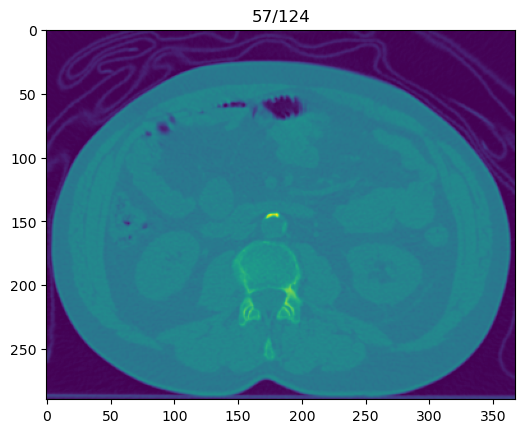

In [16]:
CT = sitk.GetArrayFromImage(sitk.ReadImage("LungPatient_3-5mmDiam_cropped.mhd", sitk.sitkFloat32))


fig, ax = plt.subplots()
ScrollView(CT).plot(ax)


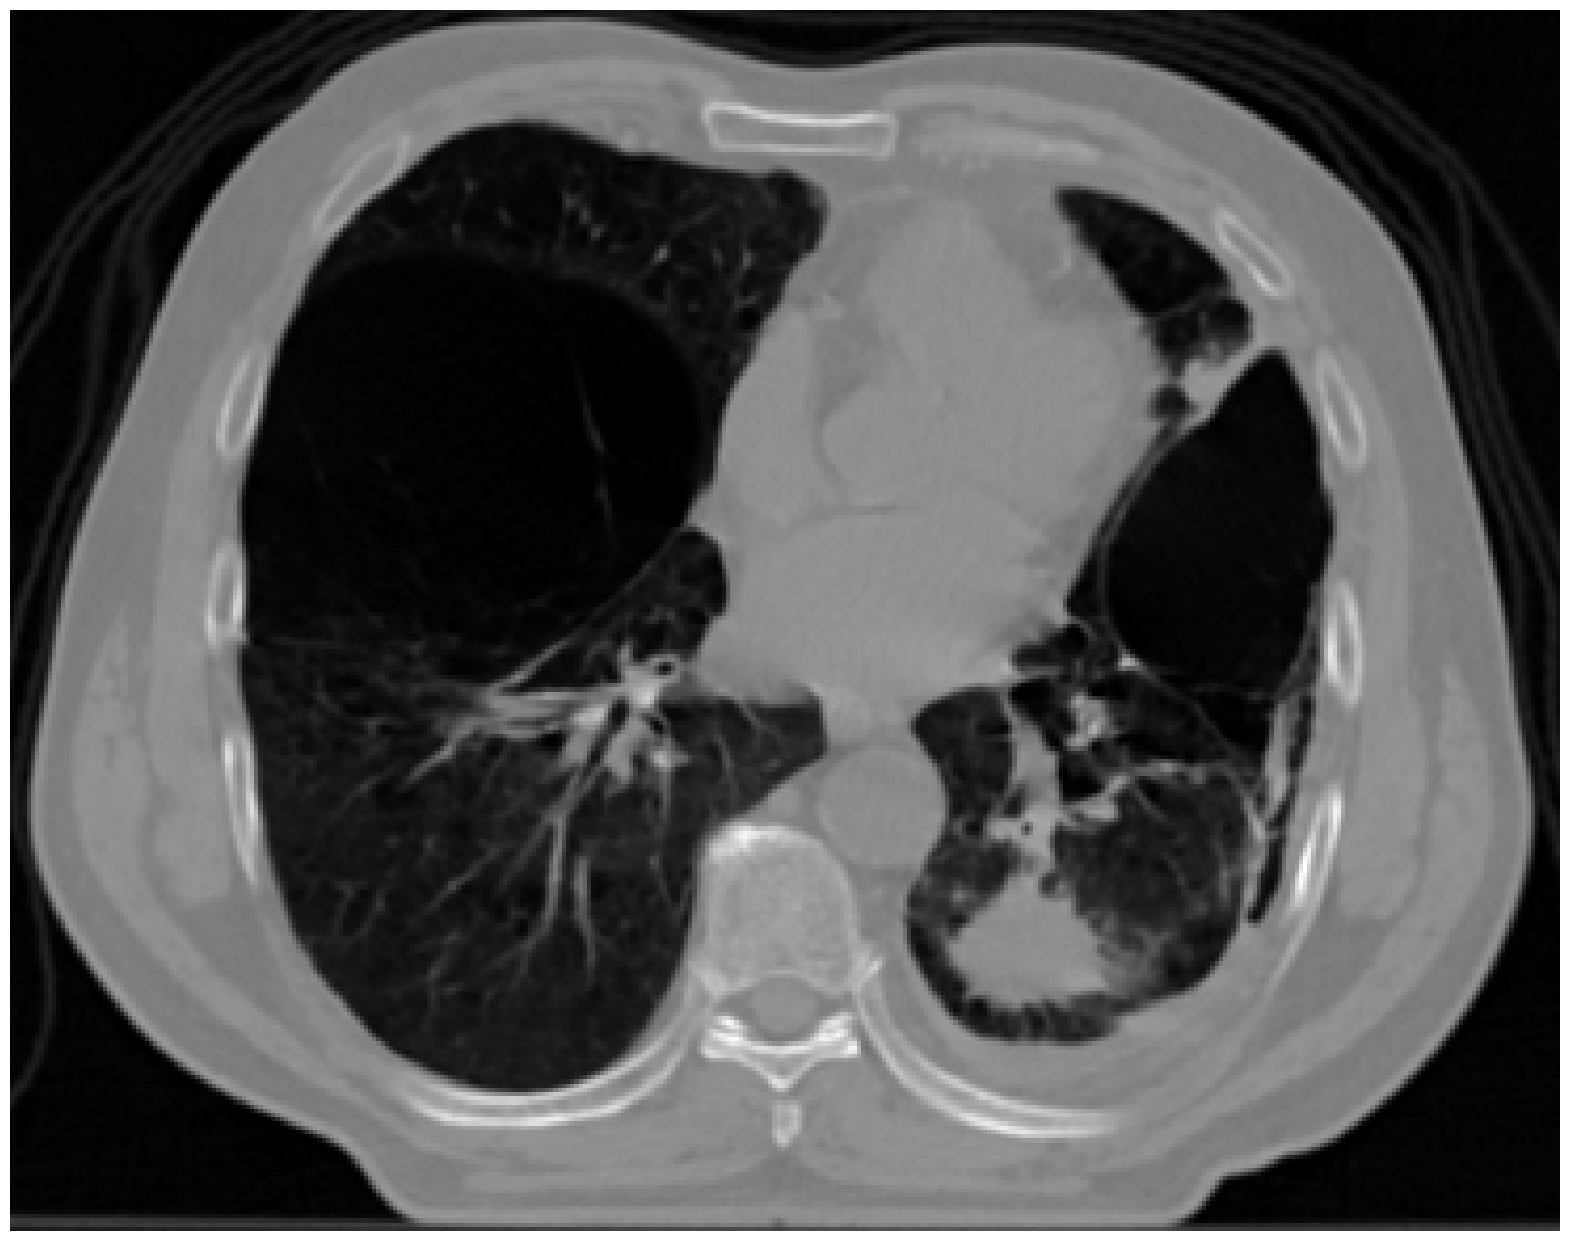

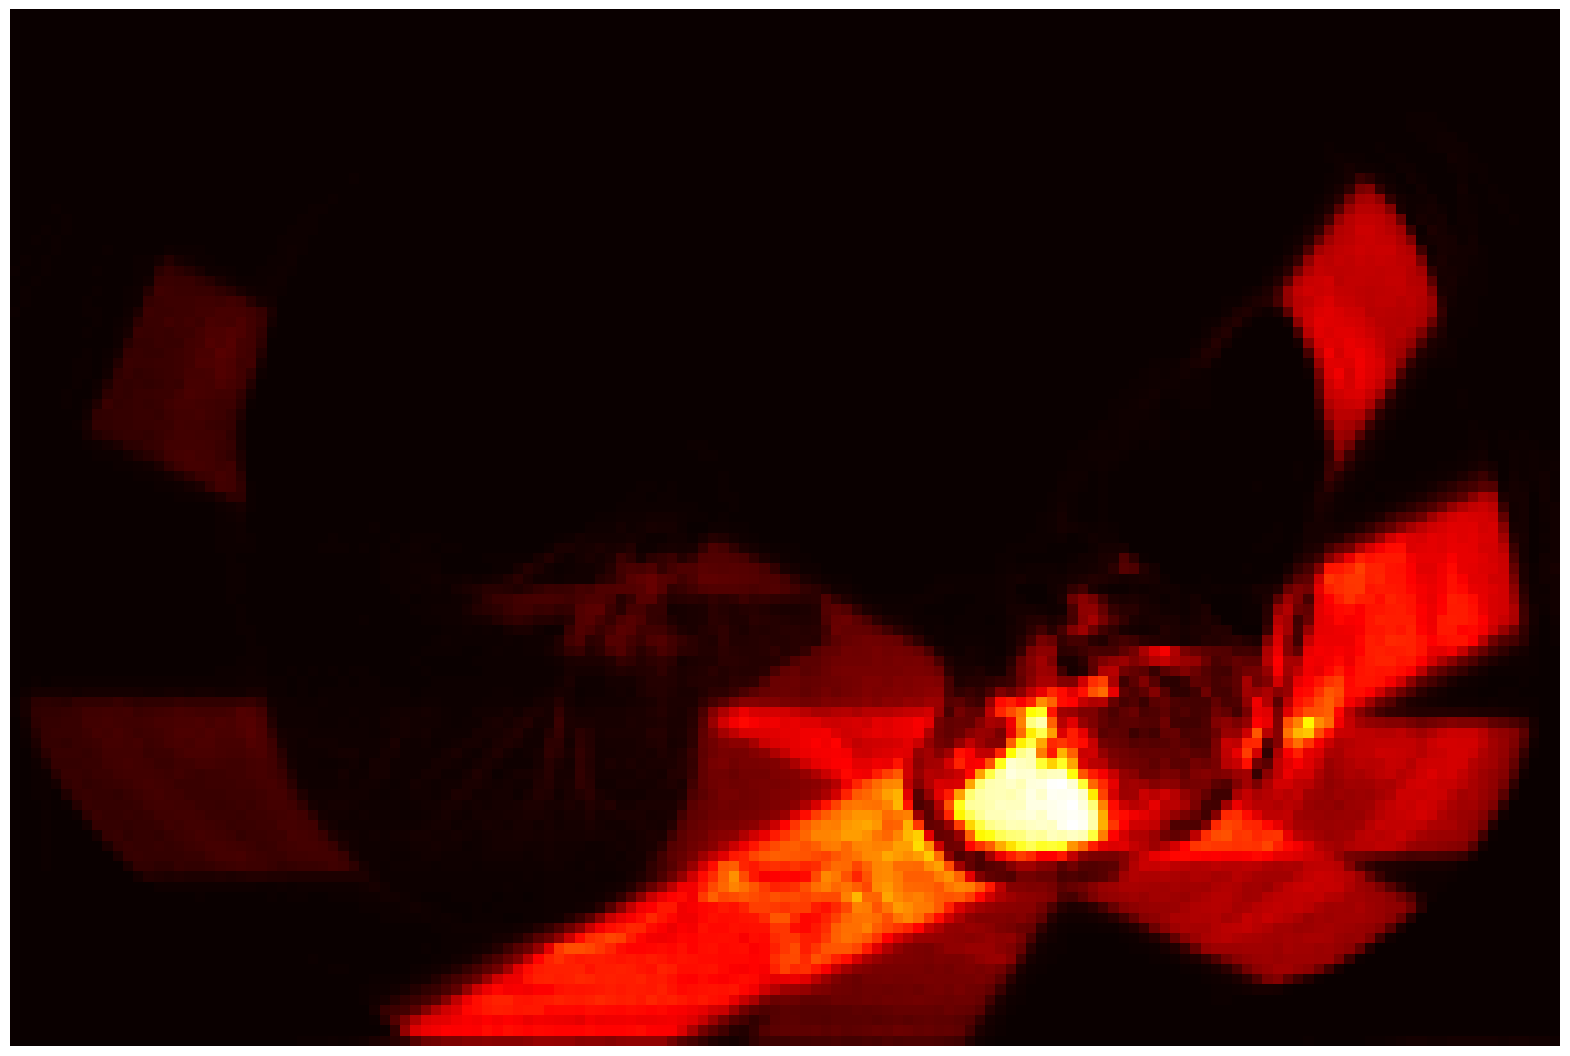

In [17]:
pospath30 = Path(os.path.join(folder30, 'ProdStop-Stop.mhd'))
pospath60 = Path(os.path.join(folder60, 'ProdStop-Stop.mhd'))
pospath90 = Path(os.path.join(folder90, 'ProdStop-Stop.mhd'))
pospath120 = Path(os.path.join(folder120, 'ProdStop-Stop.mhd'))
pospath240 = Path(os.path.join(folder240, 'ProdStop-Stop.mhd'))

pos_30degree = sitk.GetArrayFromImage(sitk.ReadImage(pospath30, sitk.sitkFloat32))
pos_60degree = sitk.GetArrayFromImage(sitk.ReadImage(pospath60, sitk.sitkFloat32))
pos_90degree = sitk.GetArrayFromImage(sitk.ReadImage(pospath90, sitk.sitkFloat32))
pos_120degree = sitk.GetArrayFromImage(sitk.ReadImage(pospath120, sitk.sitkFloat32))
pos_240degree = sitk.GetArrayFromImage(sitk.ReadImage(pospath240, sitk.sitkFloat32))

total_pos = pos_30degree + pos_60degree + pos_90degree + pos_120degree + pos_240degree

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(CT[64],cmap='gist_gray'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(total_pos[27],cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()


Composite_Positron = sitk.GetImageFromArray(total_pos)
sitk.WriteImage(Composite_Positron, 'Composite_Positron_Patient.mhd')



In [18]:
print("range of ann map: ",total_pos[27].shape[1]*2,"mm x ",total_pos[27].shape[0]*2,"mm" )

#reconstruction is centered on tumor, CT is centered in middle of CT
#displacements in GATE were -57 71 0 mm

xsize = 359.375
ysize = 283.203
zsize = 375

#image bounds should be
print("image x-bounds: ",-xsize/2-53,"mm x ",xsize/2-53,"mm" )
print("image y-bounds: ",-ysize/2+71,"mm x ",ysize/2+71,"mm" )
print("image z-bounds: ",-zsize/2,"mm x ",zsize/2,"mm" )


range of ann map:  302 mm x  202 mm
image x-bounds:  -232.6875 mm x  126.6875 mm
image y-bounds:  -70.60149999999999 mm x  212.6015 mm
image z-bounds:  -187.5 mm x  187.5 mm


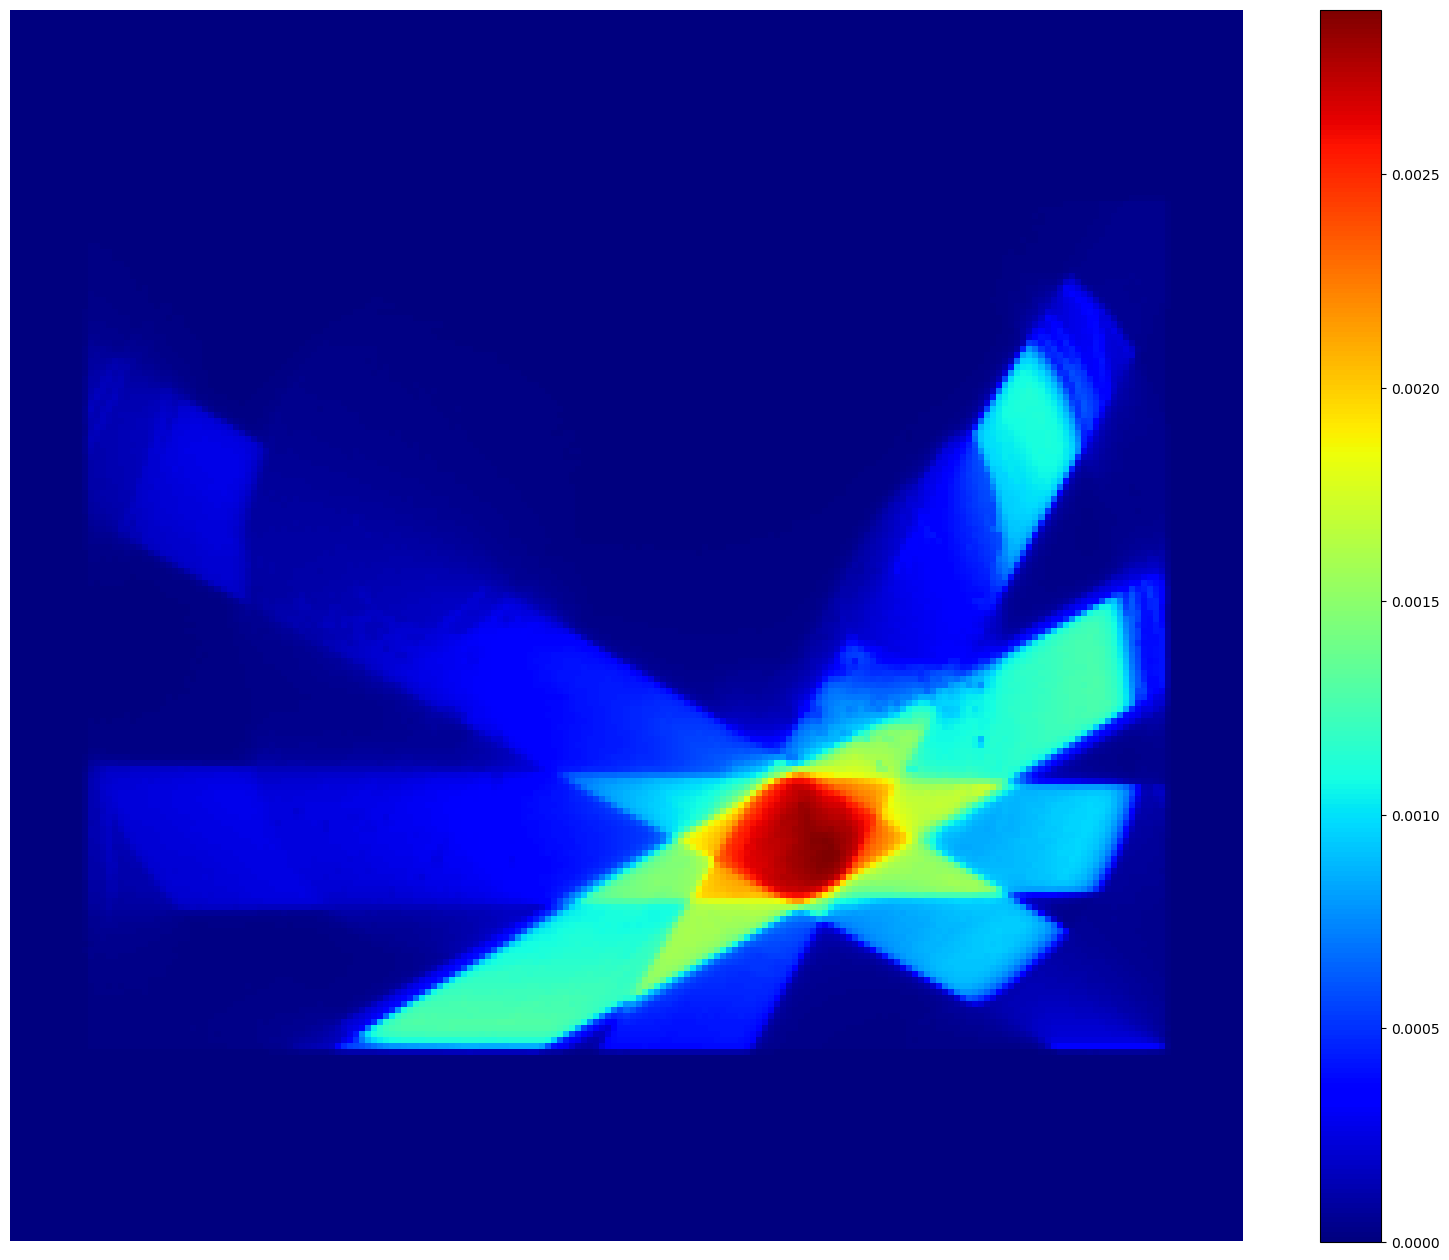

In [19]:
dosepath30 = Path(os.path.join(folder30, 'Photon-Dose.mhd'))
dosepath60 = Path(os.path.join(folder60, 'Photon-Dose.mhd'))
dosepath90 = Path(os.path.join(folder90, 'Photon-Dose.mhd'))
dosepath120 = Path(os.path.join(folder120, 'Photon-Dose.mhd'))
dosepath240 = Path(os.path.join(folder240, 'Photon-Dose.mhd'))

dose_30degree = sitk.GetArrayFromImage(sitk.ReadImage(dosepath30, sitk.sitkFloat32))
dose_60degree = sitk.GetArrayFromImage(sitk.ReadImage(dosepath60, sitk.sitkFloat32))
dose_90degree = sitk.GetArrayFromImage(sitk.ReadImage(dosepath90, sitk.sitkFloat32))
dose_120degree = sitk.GetArrayFromImage(sitk.ReadImage(dosepath120, sitk.sitkFloat32))
dose_240degree = sitk.GetArrayFromImage(sitk.ReadImage(dosepath240, sitk.sitkFloat32))

total_dose = dose_30degree + dose_60degree + dose_90degree + dose_120degree + dose_240degree 

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(total_dose[125],cmap='jet'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.colorbar()
plt.show()

Composite_Dose = sitk.GetImageFromArray(total_dose)
sitk.WriteImage(Composite_Dose, 'Composite_Dose_patient.mhd')

In [20]:
#Try to view these images in the other planes. If this can be done, image overlay is easy

#arrays are setup as z-y-x
#first input in z is a 2-d array of 101 collections of rows which makeup image

#I want an image that is y-x-z and x-z-y, so I need to transpose the 3D image.

#Since I know which index corresponds to which point

CT = sitk.GetArrayFromImage(sitk.ReadImage("LungPatient_3-5mmDiam_cropped.mhd", sitk.sitkFloat32))

total_pos = pos_30degree + pos_60degree + pos_90degree + pos_120degree + pos_240degree

total_pos_cor = total_pos.transpose(1,0,2)
total_pos_sag = total_pos.transpose(2,1,0)

CT_cor = CT.transpose(1,0,2)
CT_sag = CT.transpose(2,1,0)

print(CT.shape)
print(CT_cor.shape)
print(CT_sag.shape)

print(total_pos.shape)
print(total_pos_cor.shape)
print(total_pos_sag.shape)


(125, 290, 368)
(290, 125, 368)
(368, 290, 125)
(53, 101, 151)
(101, 53, 151)
(151, 101, 53)


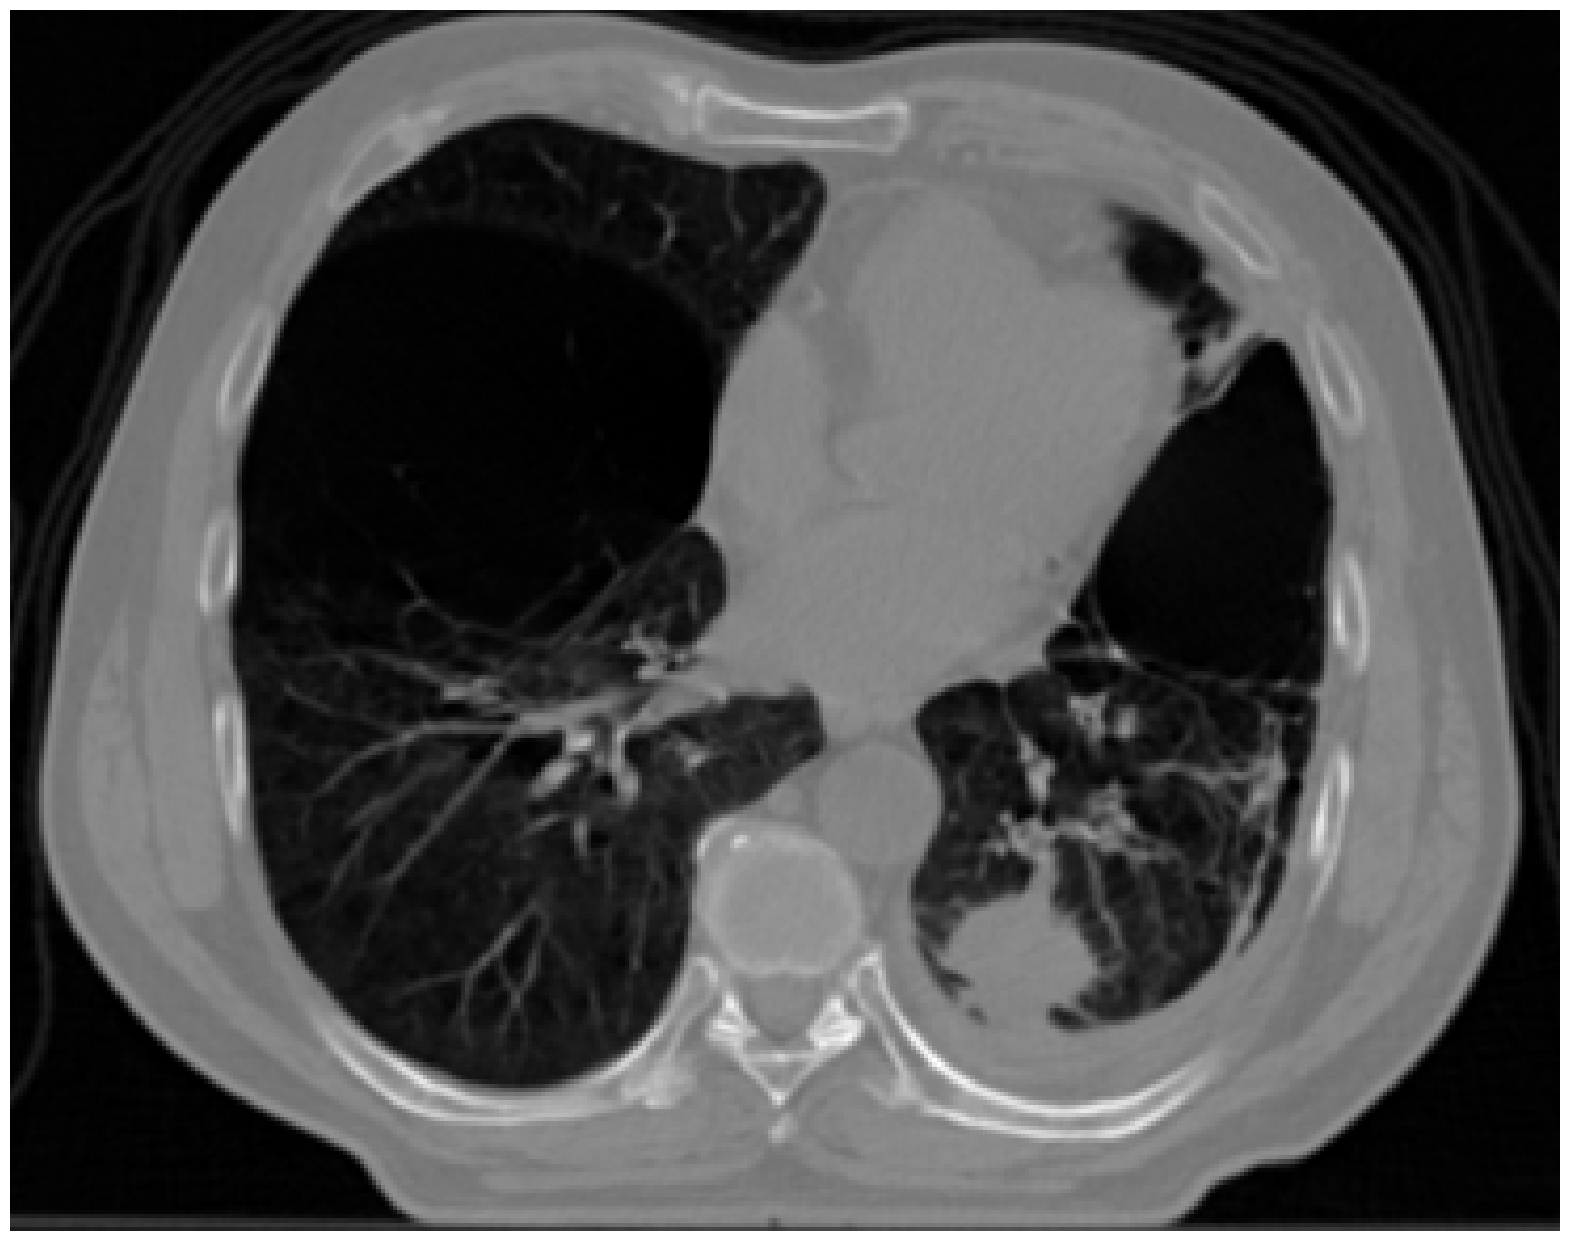

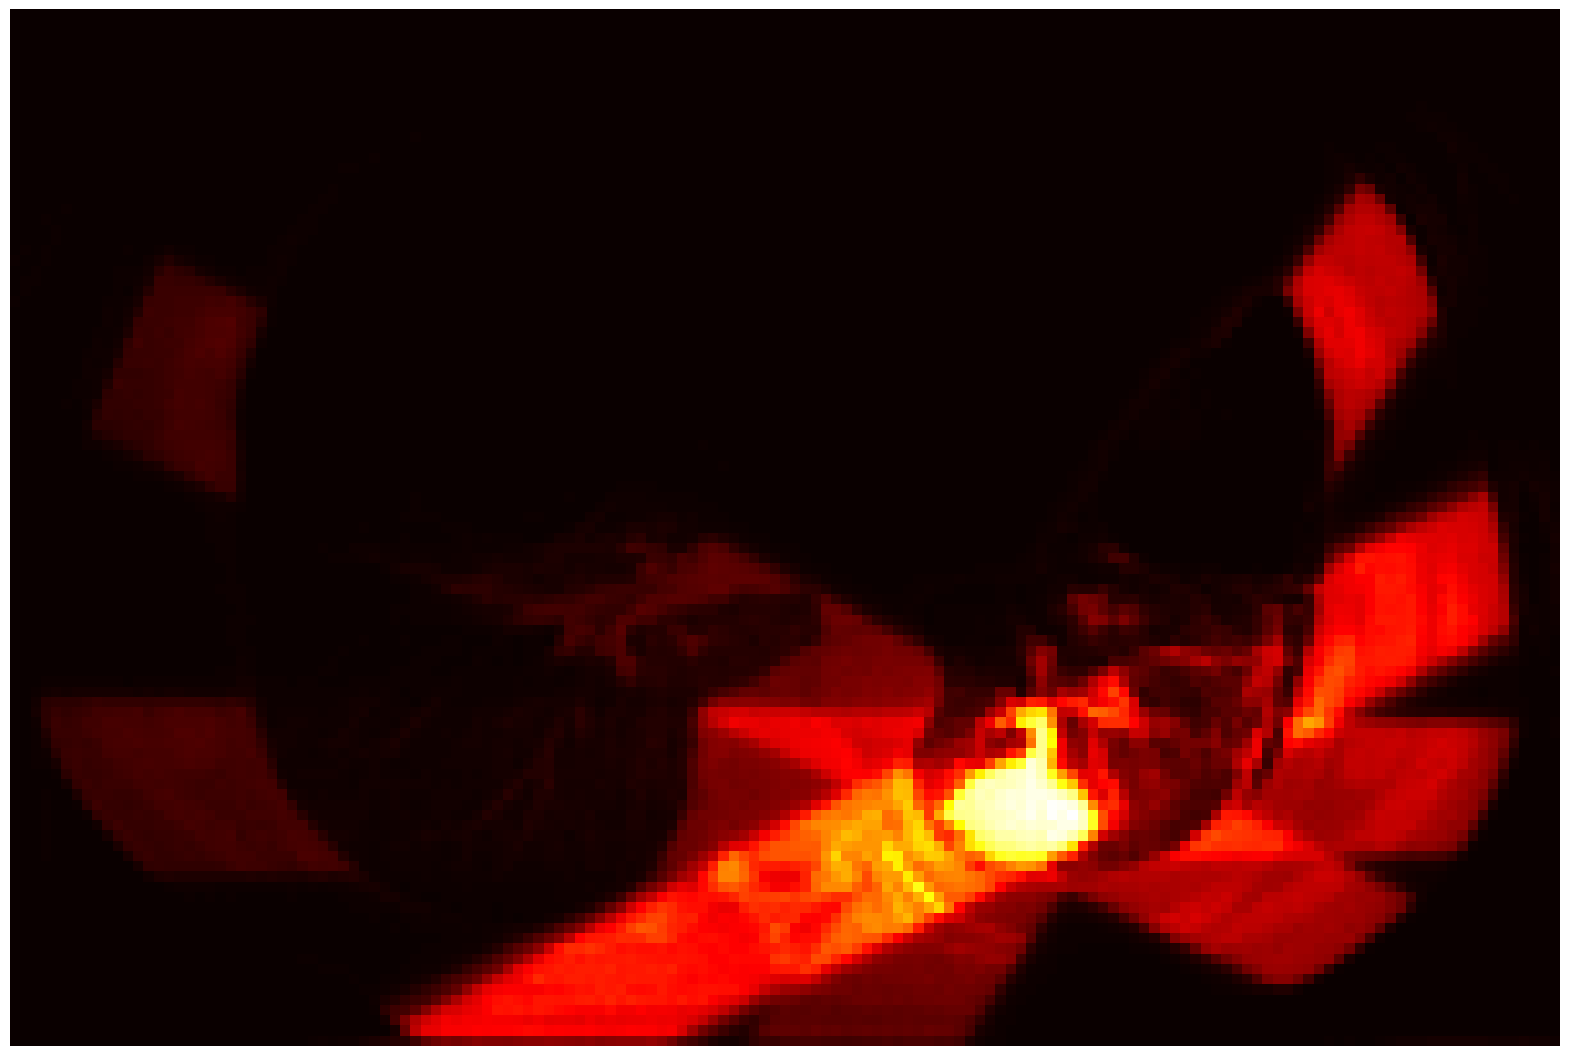

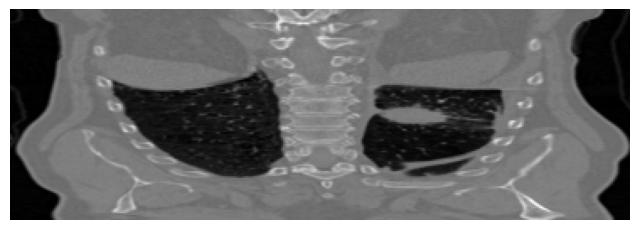

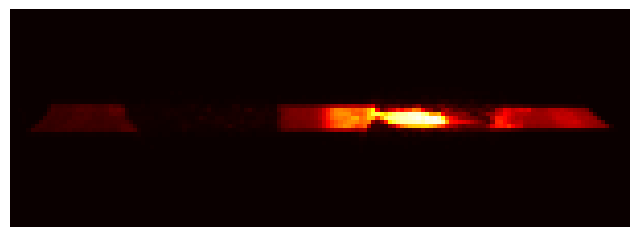

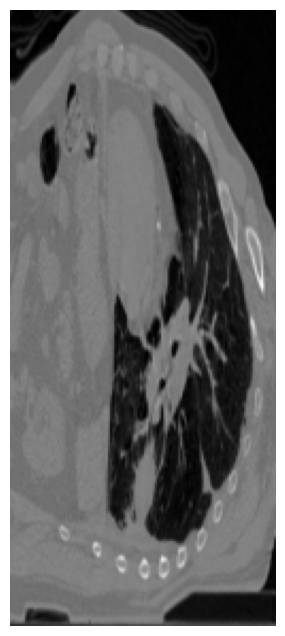

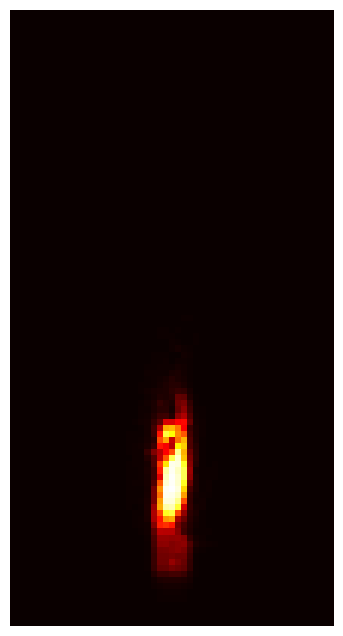

In [21]:
plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(CT[62],cmap='gist_gray'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(total_pos[26],cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(8,25))
plt.gray()
plt.imshow(CT_cor[224],cmap='gist_gray'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(8,25))
#plt.gray()
plt.imshow(total_pos_cor[78],cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(25,8))
plt.gray()
plt.imshow(CT_sag[239],cmap='gist_gray'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()


plt.figure(figsize=(25,8))
plt.gray()
plt.imshow(total_pos_sag[98],cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

In [22]:
#now save all of these as images and feed to image fusion notebook



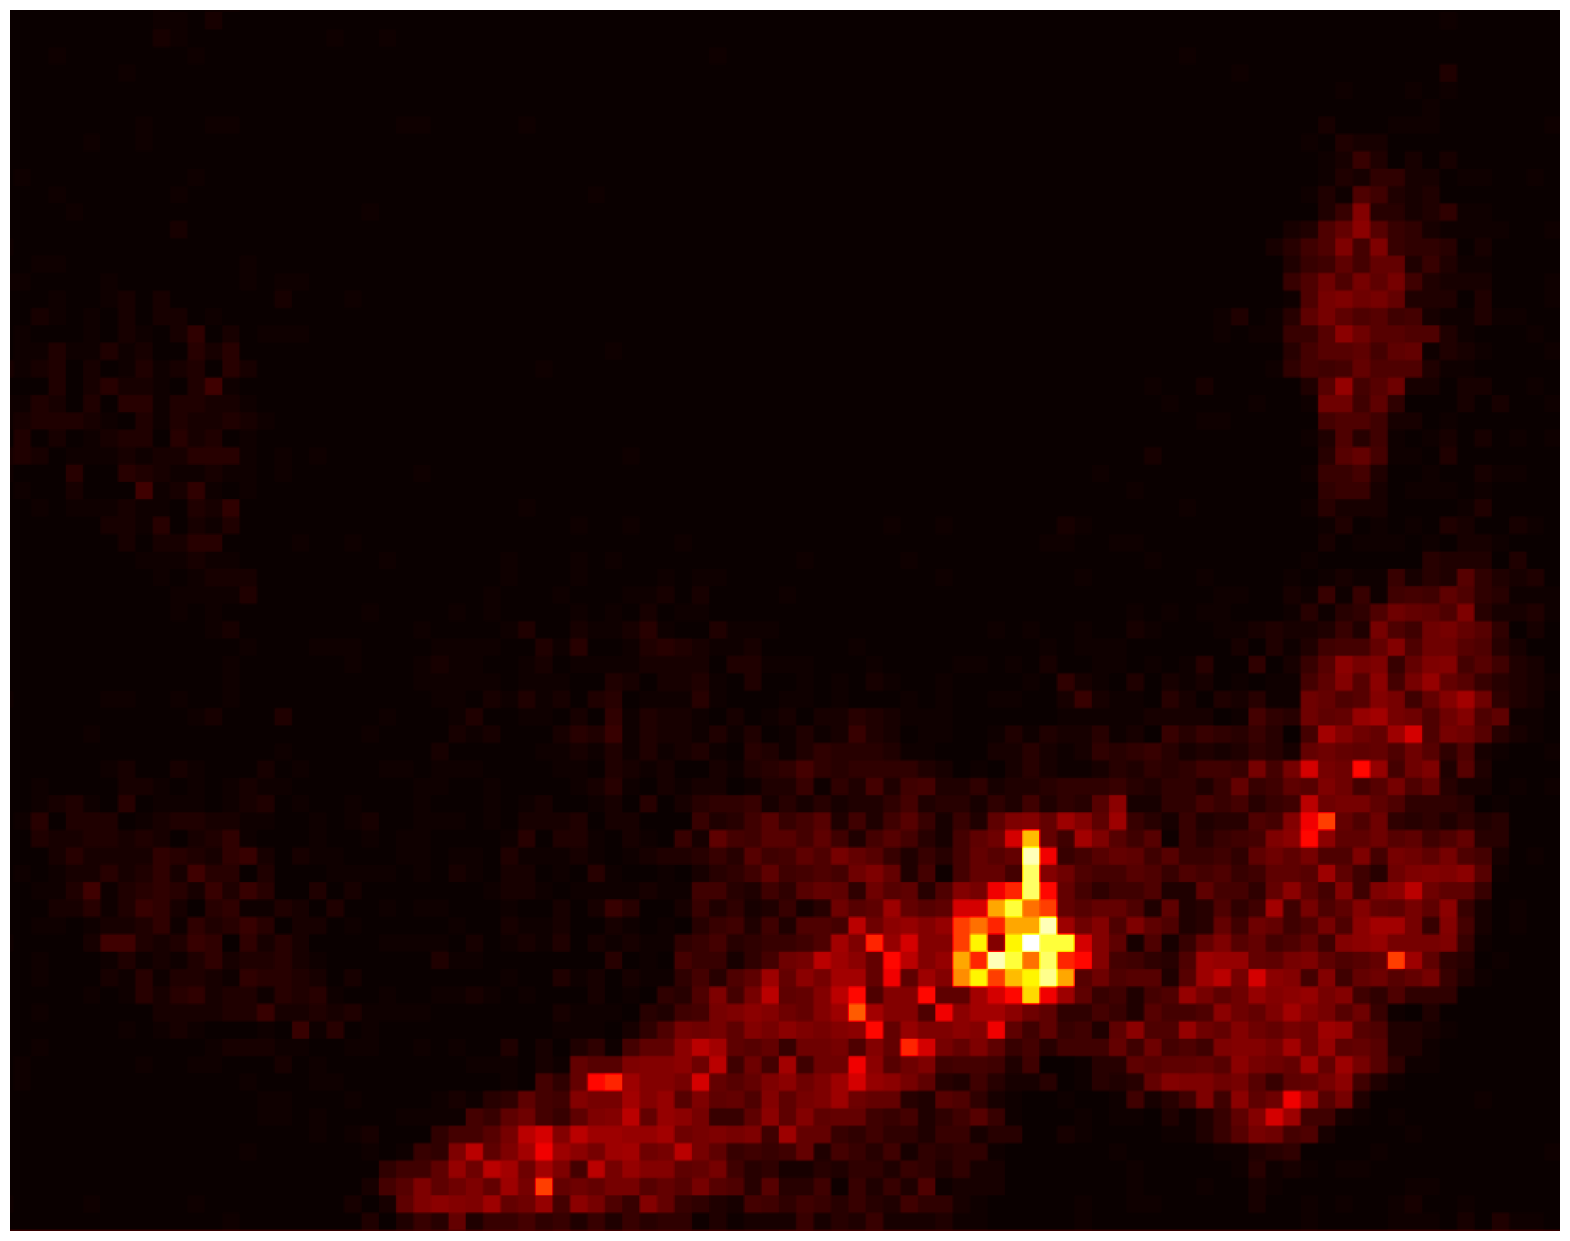

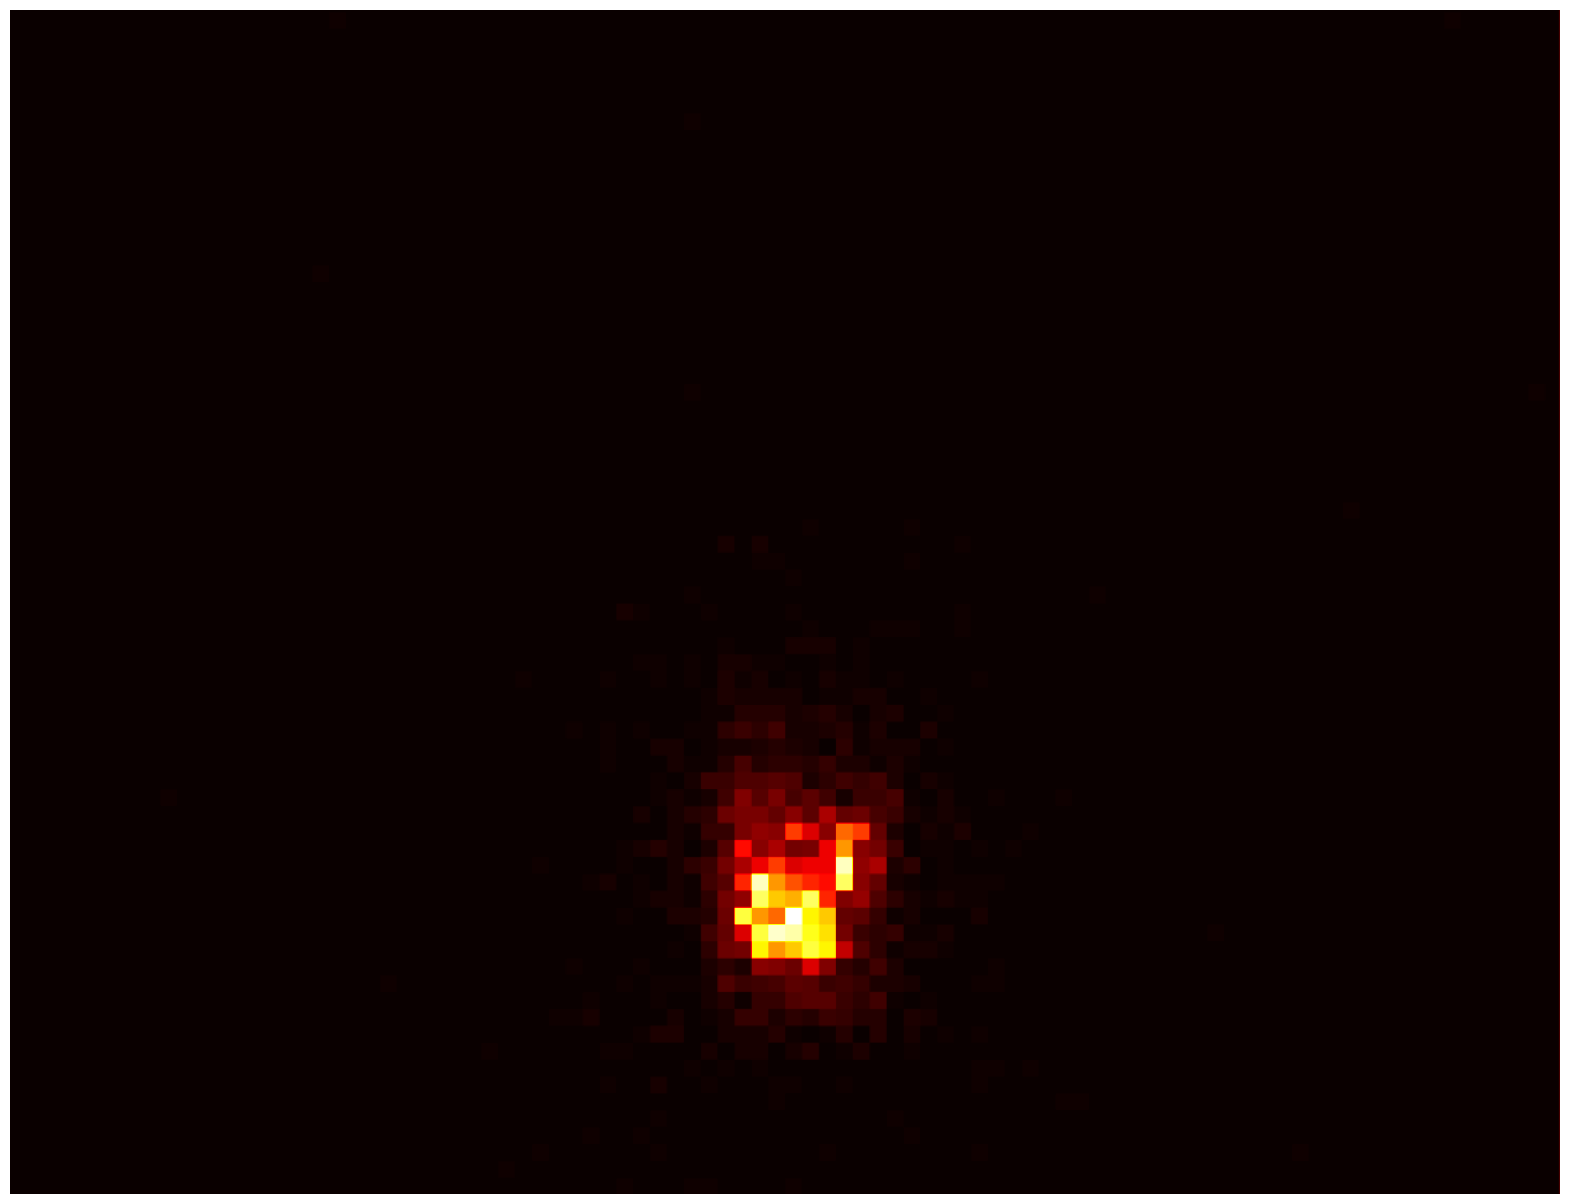

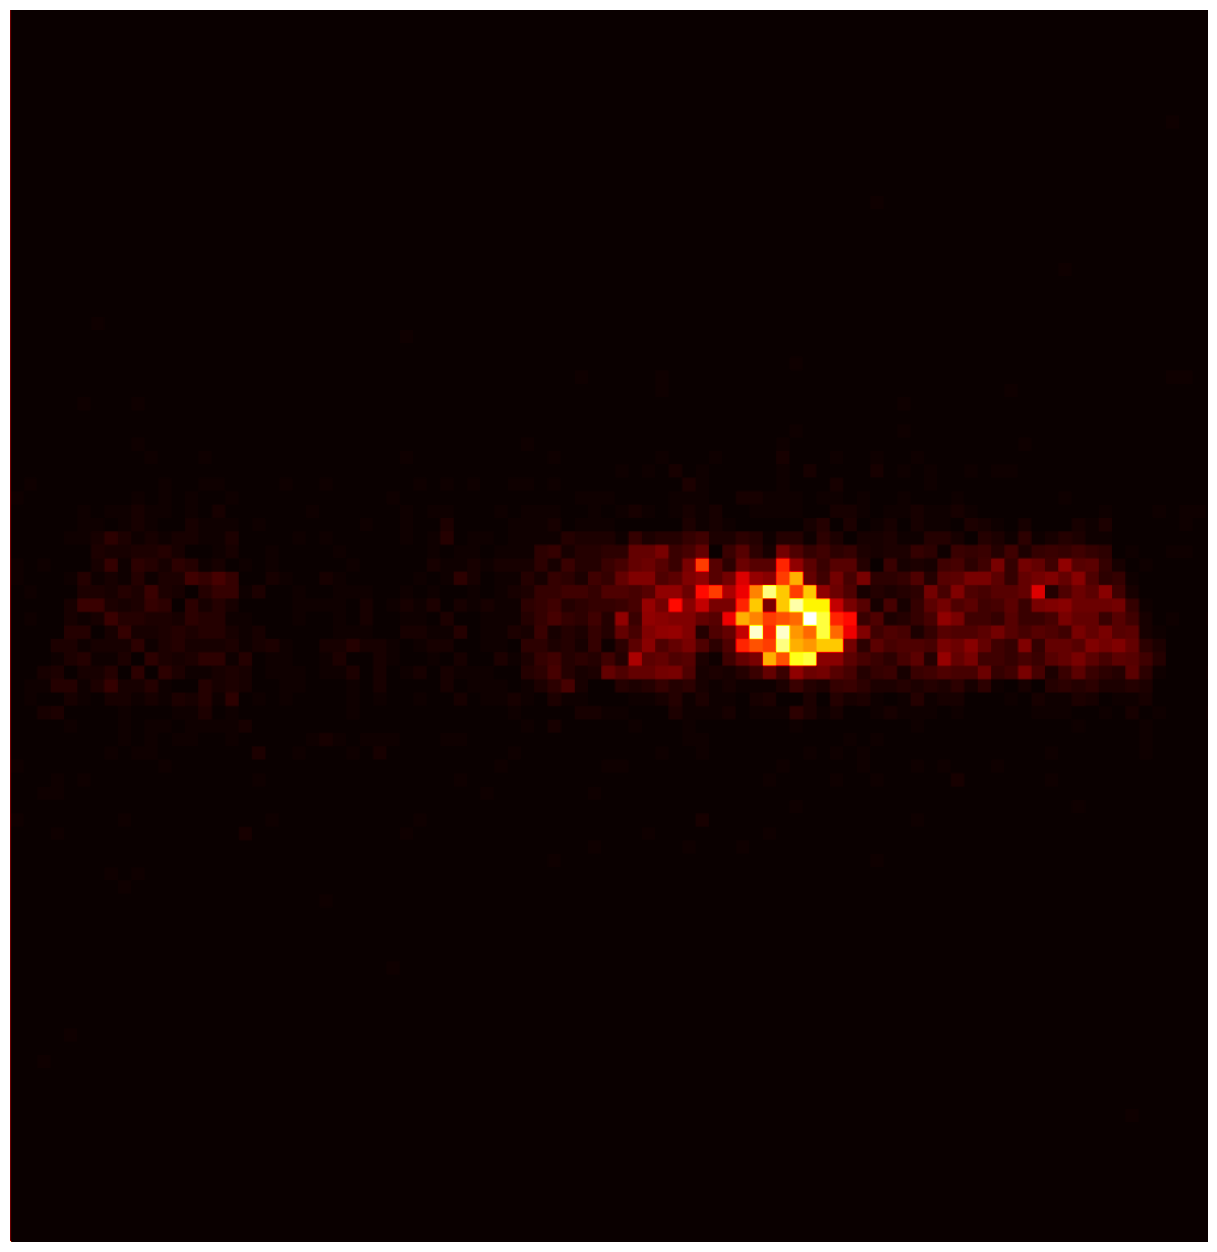

In [25]:
#display reconstruction images and save to get same format as CT images for overlay

axial_recon_path = "D:/willi/OneDrive/Documents/BWH/Research/GATE/Macros/Patient_GateLab_Results/test_axial_recon_overlay_cropped.png"

sag_recon_path = "D:/willi/OneDrive/Documents/BWH/Research/GATE/Macros/Patient_GateLab_Results/test_sag_recon_overlay.png"

cor_recon_path = "D:/willi/OneDrive/Documents/BWH/Research/GATE/Macros/Patient_GateLab_Results/test_cor_recon_overlay.png"


axial_recon = sitk.GetArrayFromImage(sitk.ReadImage(axial_recon_path, sitk.sitkFloat32))

sag_recon = sitk.GetArrayFromImage(sitk.ReadImage(sag_recon_path, sitk.sitkFloat32))

sag_recon = np.rot90(sag_recon,1)

cor_recon = sitk.GetArrayFromImage(sitk.ReadImage(cor_recon_path, sitk.sitkFloat32))

cor_recon = np.flip(cor_recon,0)

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(axial_recon,cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(sag_recon,cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()

plt.figure(figsize=(20,16))
plt.gray()
plt.imshow(cor_recon,cmap='hot'), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
#plt.colorbar()
plt.show()